oii files = 50 | lae files = 50


(0.0, 30.0)

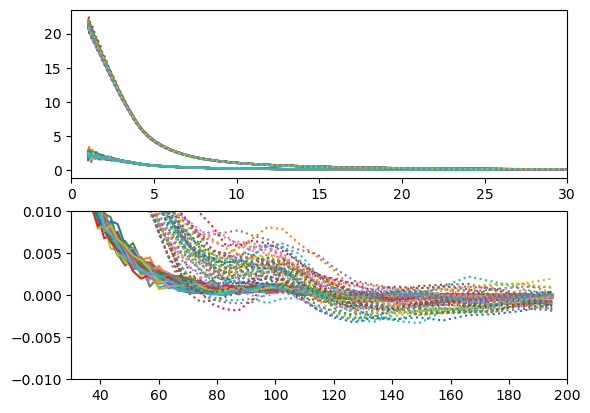

In [1]:
import h5py 
import os.path as op
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

data_dir  = '/home/qezlou/HD2/HETDEX/data/lognormal-mocks'

fnames_oii = glob(op.join(data_dir, 'corr_oii_*.hdf5'))
fnames_lae = glob(op.join(data_dir, 'corr_lae_*.hdf5'))

print(f'oii files = {len(fnames_oii)} | lae files = {len(fnames_lae)}')

all_corr = {'oii': {'corr':[],
                    'r': [],
                    'Header': {}},
            'lae': {'corr':[],
                    'r': [],
                    'Header': {}}}
fig, ax = plt.subplots(2,1)
for fn in fnames_lae:
    with h5py.File(fn, 'r') as f:
        corr = f['corr'][:]
        r = f['r'][:]
        all_corr['lae']['corr'].append(f['corr'][:])
        all_corr['lae']['r'] = r
        all_corr['lae']['z'] = f['Header'].attrs['z']
        ax[1].plot(r, corr)  
        ax[0].plot(r, corr)

for fn in fnames_oii:
    with h5py.File(fn, 'r') as f:
        corr = f['corr'][:]
        r = f['r'][:]
        all_corr['oii']['corr'].append(f['corr'][:])
        all_corr['oii']['r'] = r
        all_corr['oii']['z'] = f['Header'].attrs['z']
        ax[1].plot(r, corr, ls='dotted')   
        ax[0].plot(r, corr, ls='dotted')
ax[1].set_xlim((30, 200))
ax[1].set_ylim((-0.01, .01))
ax[0].set_xlim((0, 30))
#ax[0].set_xscale('log')


In [2]:
def plot_pecentile(stype='lae', bao=True):
    fig, ax = plt.subplots()
    percents = np.array([2.28, 15.87, 50, 84.13, 97.27])
    pcnt = np.percentile(np.array(all_corr[stype]['corr']), percents, axis=0)
   
    if bao:
        y = pcnt[2] * all_corr[stype]['r']**2
        y_up_1sigma = pcnt[3] * all_corr[stype]['r']**2
        y_low_1sigma = pcnt[1]* all_corr[stype]['r']**2
        ax.set_xlim((50, 200))
    else:
        y = pcnt[2]
        y_up_1sigma = pcnt[3]
        y_low_1sigma = pcnt[1]
        ax.set_xlim((0, 50))
    ax.plot(all_corr[stype]['r'], y, label=stype)
    ax.fill_between(all_corr[stype]['r'], y_low_1sigma, y_up_1sigma, alpha=0.5)

    fig.suptitle(stype)
    fig.tight_layout()

    return fig, ax

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

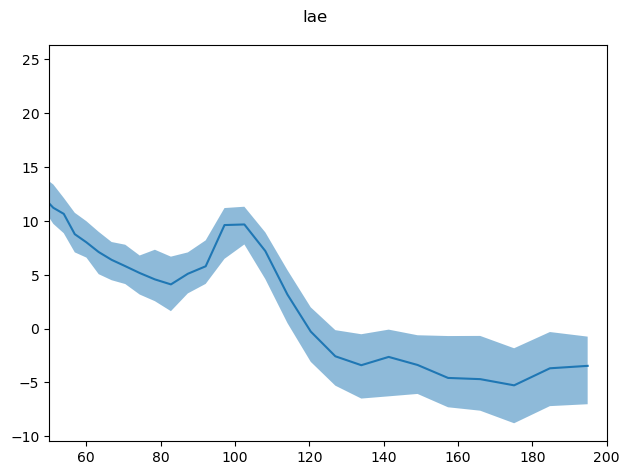

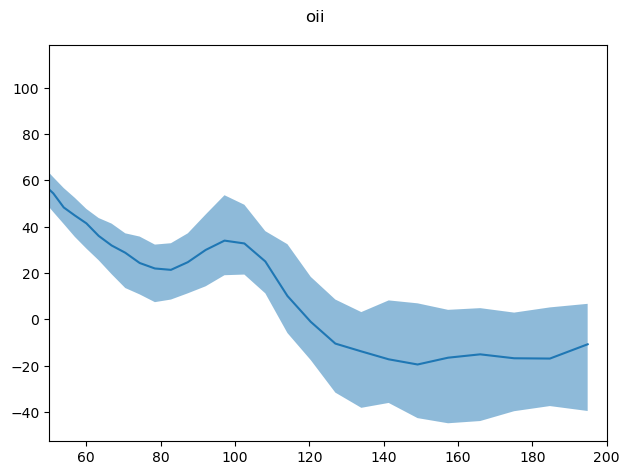

In [3]:
plot_pecentile('lae')
plot_pecentile('oii')

In [4]:
!python param_fit.py --stype 'oii' --optimize True --r_range 80 130
!python param_fit.py --stype 'lae' --optimize True --r_range 80 130

usage: param_fit.py [-h] [--stype STYPE] [--optimize OPTIMIZE]
                    [--r_range R_RANGE R_RANGE] [--stack STACK]
param_fit.py: error: argument --optimize: invalid int value: 'True'
usage: param_fit.py [-h] [--stype STYPE] [--optimize OPTIMIZE]
                    [--r_range R_RANGE R_RANGE] [--stack STACK]
param_fit.py: error: argument --optimize: invalid int value: 'True'


In [5]:
from nbodykit import cosmology

def get_linear_corr(r=None, z=2.2,  h=0.7, sigma8=0.70):
    if r is None:
        r = np.logspace(np.log10(60), np.log10(150), 1000)
    cosmo = cosmology.Planck15
    print(cosmo.h)
    cosmo = cosmo.clone(h=h)

    Plin = cosmology.LinearPower(cosmo, redshift=z, transfer='EisensteinHu')
    Plin.sigma8 = sigma8
    cf_lin = cosmology.CorrelationFunction(Plin)
    return cf_lin(r)


0.6774


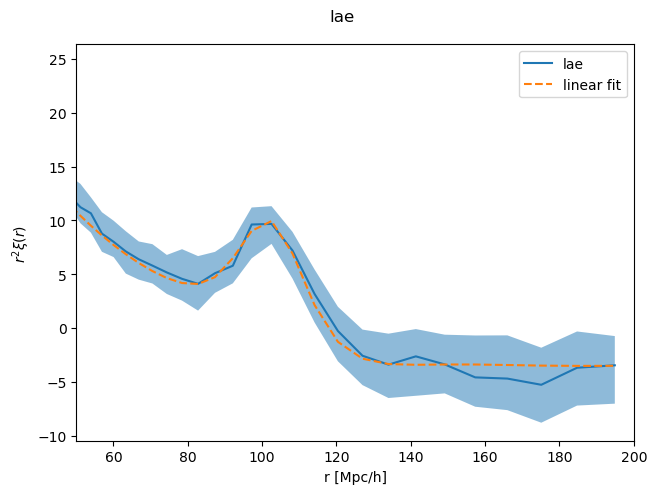

In [6]:
r = all_corr['lae']['r']
corr = all_corr['lae']['corr']
cf_lin = get_linear_corr(r=r, h=0.664, sigma8=1.561, z=2.2)

fig, ax = plot_pecentile('lae', bao=True)

ax.plot(r, cf_lin * r**2, label='linear fit', ls='--')
ax.set_xlabel('r [Mpc/h]')
ax.set_ylabel(r'$r^2 \xi(r)$')
ax.legend()

0.6774


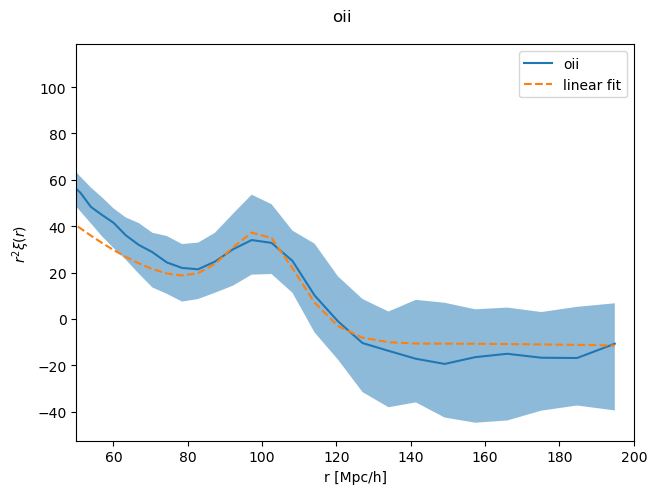

In [7]:
r = all_corr['oii']['r']
corr = all_corr['oii']['corr']
cf_lin = get_linear_corr(r=r, h=0.6045, sigma8=1.2412, z=0.25)

fig, ax = plot_pecentile('oii', bao=True)

ax.plot(r, cf_lin * r**2, label='linear fit', ls='--')
ax.set_xlabel('r [Mpc/h]')
ax.set_ylabel(r'$r^2 \xi(r)$')
ax.legend()

In [14]:
import h5py
from matplotlib import pyplot as plt
def maximumn_posterior_dist(stype='oii'):
    fits_file = op.join(data_dir, f'fits_{stype}.hdf5')
    with h5py.File(fits_file, 'r') as f:
        mp = f['fits'][:]
    fig, ax = plt.subplots(1,2)
    ax[0].hist(mp[:,0], bins=5)
    ax[0].axvline(0.6774, color='r')
    ax[0].text(0.6774, ax[0].get_ylim()[1]*0.9, 'true', color='r', rotation=90)
    ax[1].hist(mp[:,1], bins=5)
    ax[0].set_xlabel('h')
    ax[1].set_xlabel('sigma8')
    fig.suptitle(stype)

In [15]:
def compare_individual_fits(stype):
    fits_file = op.join(data_dir, f'fits_{stype}.hdf5')
    with h5py.File(fits_file, 'r') as f:
        mp = f['fits'][:]
        r_range = (f['r'][0], f['r'][-1])
    z = all_corr[stype]['z']
    r = all_corr[stype]['r']
    ind = np.where((r >= r_range[0]) & (r <= r_range[1]))[0]
    r = r[ind]
    fig, ax = plt.subplots(5,2, figsize=(12, 15))
    rnd_set = np.random.randint(0, 50, 10)
    for c, i in enumerate(rnd_set):
        x = c // 2
        y = c % 2
        h, sigma8 = mp[i]
        corr = all_corr[stype]['corr'][i][ind]
        cf_lin = get_linear_corr(r=r, h=h, sigma8=sigma8, z=z)
        ax[x,y].plot(r, cf_lin * r**2, label='linear fit', ls='--', color=f'C{c}')
        ax[x,y].plot(r, corr*r**2, label='Mock lognormal', color=f'C{c}')
        ax[x,y].set_xlabel('r')
        ax[x,y].set_ylabel(r'$r^2 * \xi$')
    fig.suptitle(f'{stype}', fontsize=20)
    fig.tight_layout() 

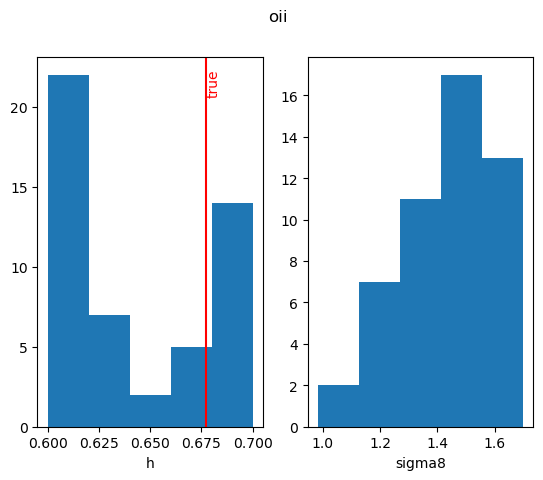

In [16]:
maximumn_posterior_dist('oii')

0.6774
0.6774
0.6774
0.6774
0.6774
0.6774
0.6774
0.6774
0.6774
0.6774


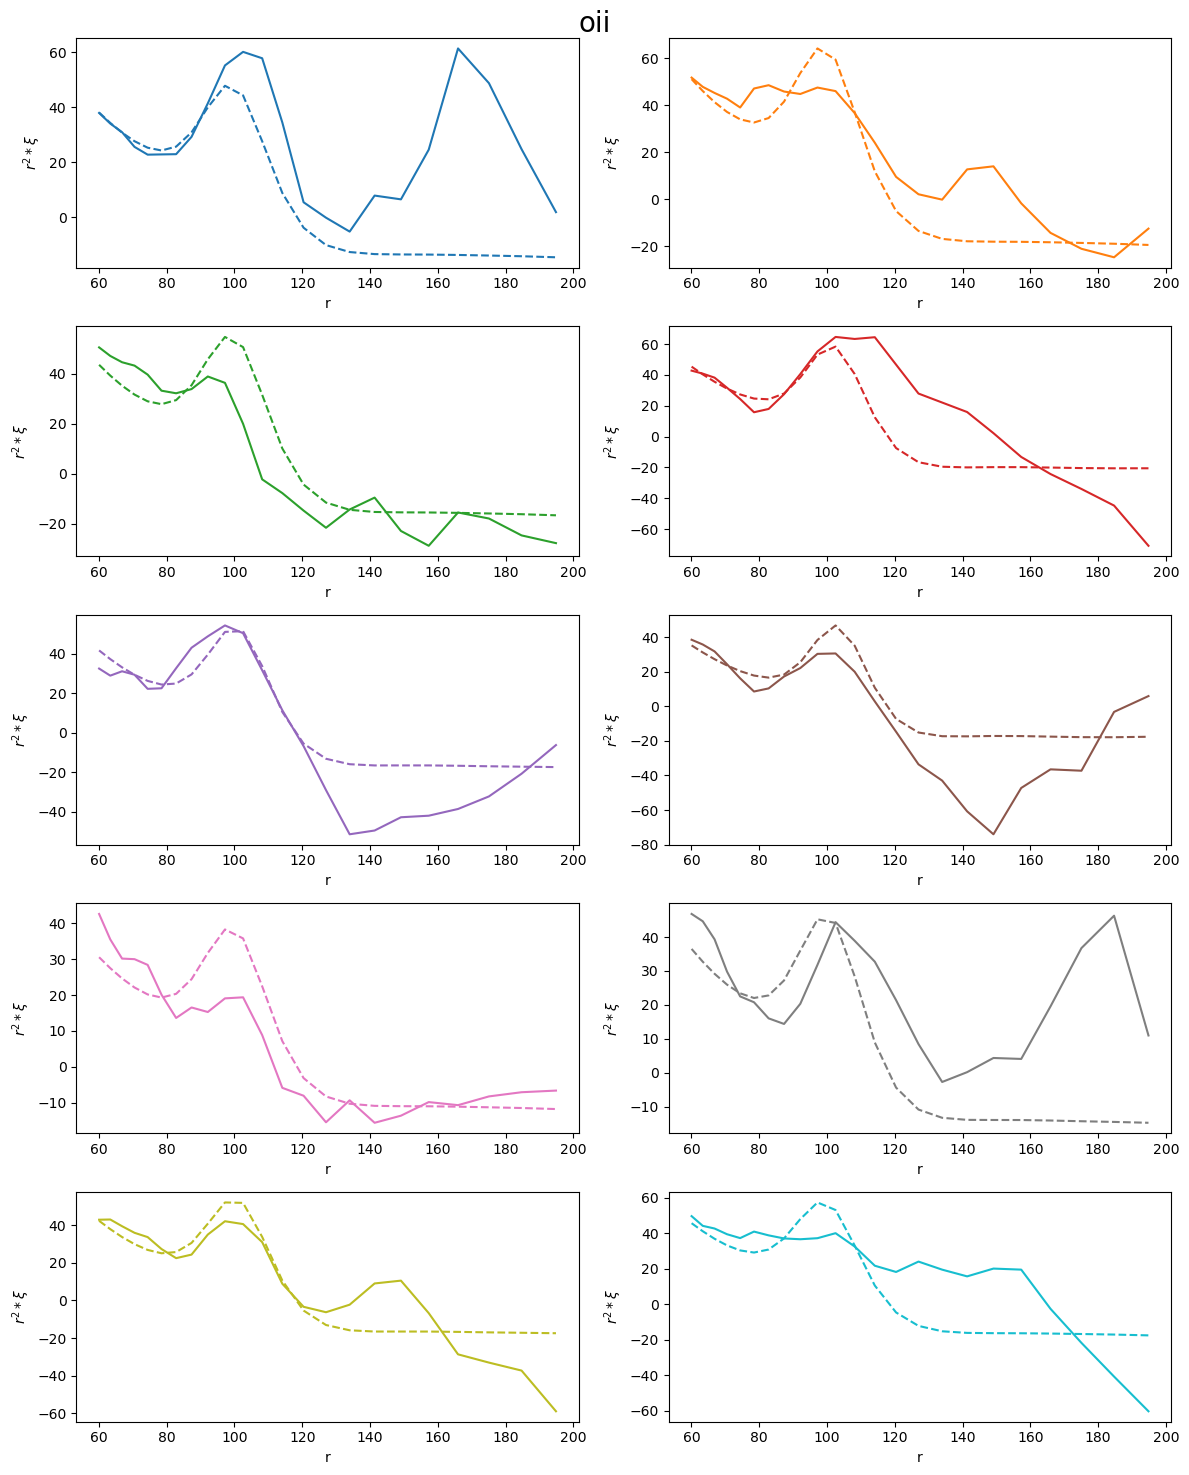

In [52]:
compare_individual_fits('oii')

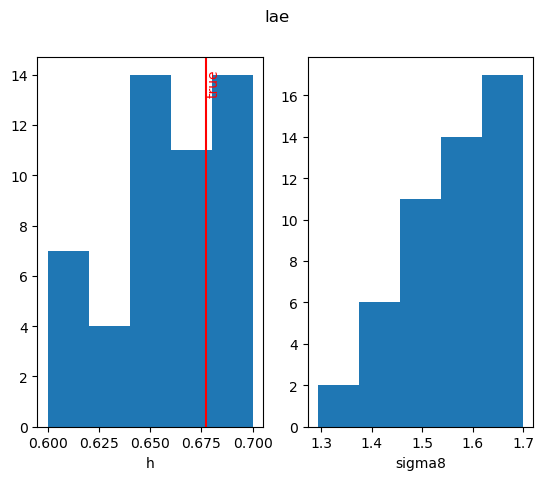

In [74]:
maximumn_posterior_dist('lae')

0.6774
0.6774
0.6774
0.6774
0.6774
0.6774
0.6774
0.6774
0.6774
0.6774


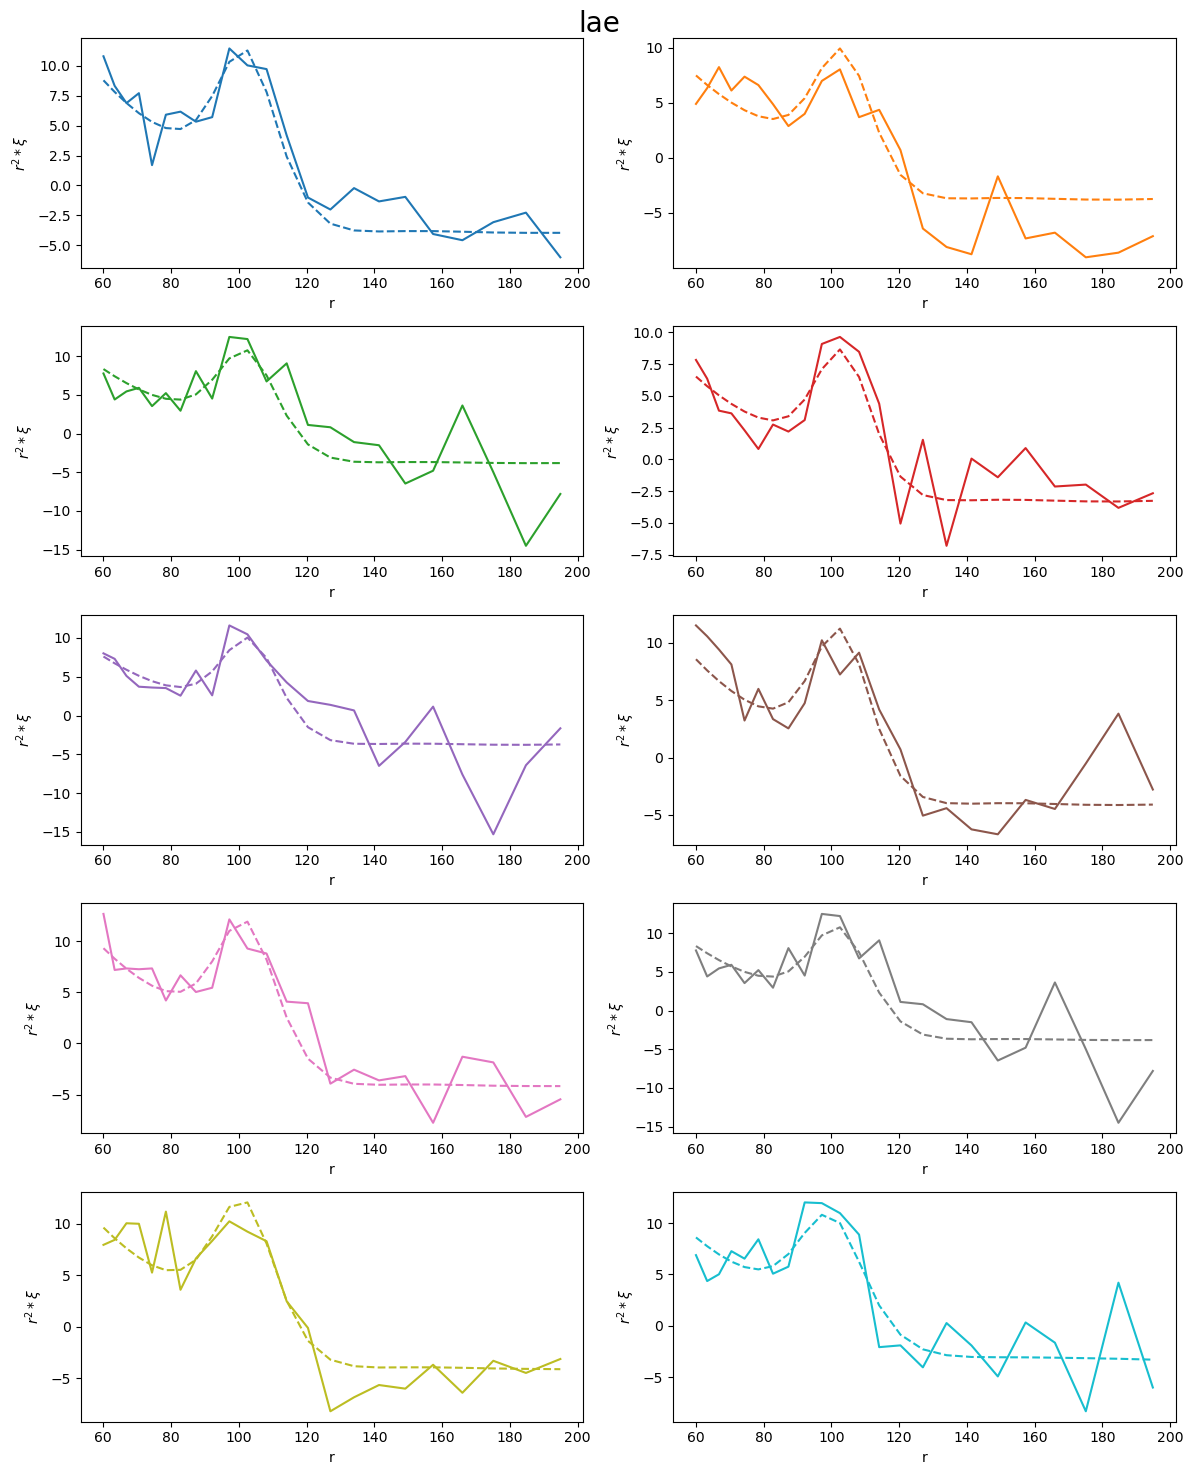

In [54]:

compare_individual_fits('lae')

In [24]:
import h5py
from matplotlib import pyplot as plt
def maximumn_posterior_dist(fname):
    fits_file = op.join(data_dir, fname)
    with h5py.File(fits_file, 'r') as f:
        mp = f['fits'][:]
        fig, ax = plt.subplots(1,2)
        ax[0].hist(mp[:,0], bins=10)
        ax[0].axvline(0.6774, color='r')
        ax[0].text(0.6774, ax[0].get_ylim()[1]*0.9, 'true', color='r', rotation=90)
        ax[1].hist(mp[:,1], bins=10)
        ax[0].set_xlabel('h')
        ax[1].set_xlabel('sigma8')
        fig.suptitle(fname)

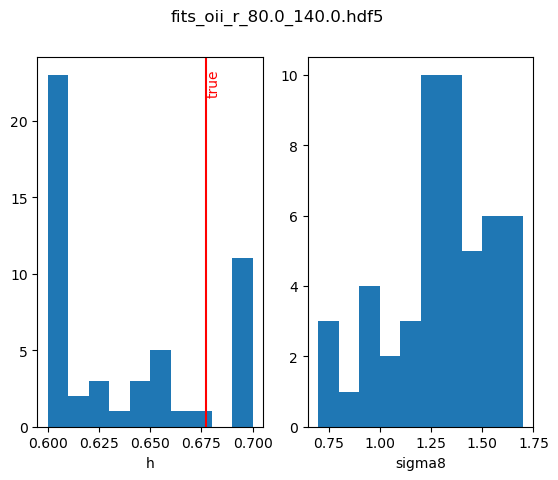

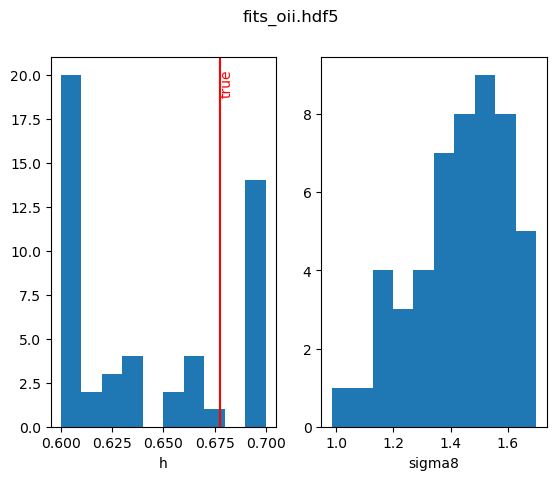

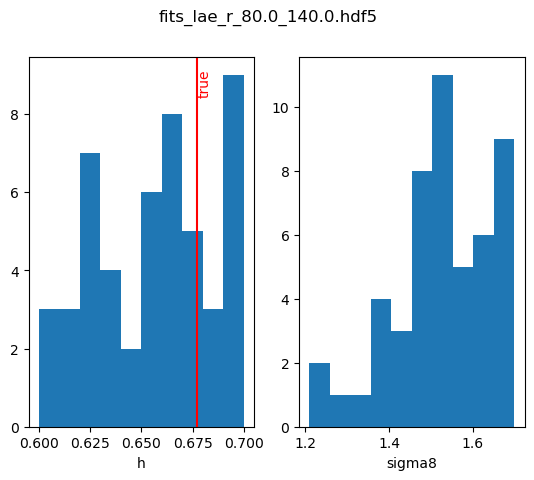

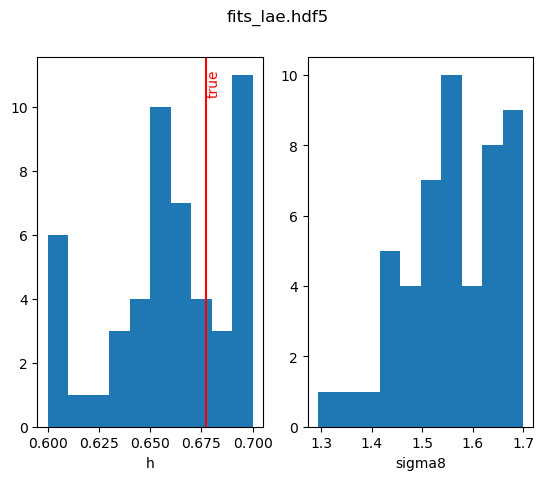

In [25]:
maximumn_posterior_dist(f'fits_oii_r_80.0_140.0.hdf5')
maximumn_posterior_dist(f'fits_oii.hdf5')
maximumn_posterior_dist(f'fits_lae_r_80.0_140.0.hdf5')
maximumn_posterior_dist(f'fits_lae.hdf5')

Next:

- [ ] Get more mocks for better maximum a posterior distibution
- Ask Julian for a better comparison metric